 # Predicting Heart Disease Using Medical Data with the KNN Algorithm  
 
 
 #### By Chris Jung, Jamie Ma and Amy Wu
 ## 1. Introduction
 ### 1.1 Background and Motivation
***Heart disease*** is the leading cause of death for most of countries in the world, even countries with advanced medical technology such as the United States. About 659,000 people in the US die from heart disease each year, which accounts for 1 in every 4 deaths. It costs the United States about $363 billion each year from 2016 to 2017. [[1]](https://www.who.int/health-topics/cardiovascular-diseases) For those reasons, it would be beneficial for everyone if we are able to analyze the factors causing heart disease, predict heart disease using the analysis and prevent it from happening beforehand. 

 ### 1.2 Project Goal
Furthermore, we are going to use actual medical records from the Cleveland Clinic Foundation to make a **heart disease prediction model** using the K-nearest neighbors (KNN) classification algorithm. Then we will **evaluate our model** to determine if it is good model by analyzing the parameters and accuracy of the model. By doing these activities, we hope to answer this question:

##### Given a new observation with age, max heart rate, and ST depression as predictors, can we accurately predict the **presence** of heart disease?


 ### 1.3 Data
The dataset is from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Heart+Disease). Each observation contains 14 attributes of **a person's medical information** including the presence of heart disease. From 13 attributes excluding "Class" that we will predict, we picked 3 attributes as our predictors with following two criteria. First, predictors should be numerical/non-categorical attributes so that they can be used for KNN classification. Secondly, predictors should be relevant attributes for heart disease prediction that are frequently used in the medical research field. We referred to this [literature [2]](https://www.ijrte.org/wp-content/uploads/papers/v8i2S3/B11630782S319.pdf) that analyzes the relevance of commonly used attributes for heart disease predictions and excluded the two numerical attributes that are not in top 10 relevant attributes from our predictors.

Below is the name and explanations of the 3 selected attributes that meet both the criteria and the *Class* attribute that we want to predict using the 3 predictors. 
1. age: age of the person in years
2. thalach: maximum heart rate achieved in bpm (Beat Per Minute)
3. oldpeak: ST depression induced by exercise relative to rest in mm 
4. *Class*: presence of heart disease: no presence (0) and presence (1-4)

In [1]:
#loads the libraries
library(tidyverse)
library(repr)
library(tidymodels)
library(GGally)

#sets the seed for random events such as splitting the data
set.seed(1000)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

## 2. Methods and Results

### 2.1 Reading and Wrangling

### Reading the Data
We loaded the original data with 14 attributes from the web and corrected the data types of the numeric attributes that were treated as characters. In addition, since `X14` corresponds to the class of heart diseases, the one we want to predict, we converted it to a factor.  

In [2]:
#reads in the data table with the 14 attributes
heart_data_raw <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data",
              col_names = FALSE) %>%
              mutate(X12 = as.numeric(X12), X13 = as.numeric(X13), X14 = as.factor(X14))

#outputs the first 6 rows of the data frame
head(heart_data_raw)

Parsed with column specification:
cols(
  X1 = col_double(),
  X2 = col_double(),
  X3 = col_double(),
  X4 = col_double(),
  X5 = col_double(),
  X6 = col_double(),
  X7 = col_double(),
  X8 = col_double(),
  X9 = col_double(),
  X10 = col_double(),
  X11 = col_double(),
  X12 = col_character(),
  X13 = col_character(),
  X14 = col_double()
)

Warning message:
“Problem with `mutate()` input `X12`.
ℹ NAs introduced by coercion
ℹ Input `X12` is `as.numeric(X12)`.”
Warning message in mask$eval_all_mutate(dots[[i]]):
“NAs introduced by coercion”
Warning message:
“Problem with `mutate()` input `X13`.
ℹ NAs introduced by coercion
ℹ Input `X13` is `as.numeric(X13)`.”
Warning message in mask$eval_all_mutate(dots[[i]]):
“NAs introduced by coercion”


X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
67,1,4,160,286,0,2,108,1,1.5,2,3,3,2
67,1,4,120,229,0,2,129,1,2.6,2,2,7,1
37,1,3,130,250,0,0,187,0,3.5,3,0,3,0
41,0,2,130,204,0,2,172,0,1.4,1,0,3,0
56,1,2,120,236,0,0,178,0,0.8,1,0,3,0


Fig 1: Untidy dataframe

### Wrangling the data
In order to finish wrangling the data, we converted the column names into names that are human-readable. We decided to convert them all into the names given by the data set as outlined in the introduction, except for the last column which we named `Class`.
### Binary Classification Using Multiple Categories
The original `Class` column had 5 values ranging from 0 to 4 (0: no presence of heart disease, 1-4: different classes of heart disease). After finding that about half of the observations have class `0`, while the other half make up the other classes, we decided to group the `Class` into two categories, presence or not. Also, limiting our model to only predict two categories rather than five will increase the accuracy of our classifier. For these reasons, we replaced any values of 0 with `0` and any other values (1-4) with `1`.

In [3]:
#renames the columns
colnames(heart_data_raw) <- c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak",
                          "slope", "ca", "thal", "Class")

#selects the 5 predictors and class that will be used as well as converts the class into either 0 for value = 0 or 1 for values = [1-4]
heart_data <- select(heart_data_raw, age, thalach, oldpeak, Class) %>%
    mutate(Class = case_when((Class == 0) ~ 0, (Class != 0) ~ 1)) %>%
    mutate(Class = as_factor(Class))

#outputs the first 6 rows of the data frame
head(heart_data)

age,thalach,oldpeak,Class
<dbl>,<dbl>,<dbl>,<fct>
63,150,2.3,0
67,108,1.5,1
67,129,2.6,1
37,187,3.5,0
41,172,1.4,0
56,178,0.8,0


Fig 2: Dataframe containing the 5 predictors and the new `Class` categories

### Splitting the data
We chose a 75/25 split to offer the model a good balance between optimizing its accuracy through training data and maintaining enough data to test the accuracy. `Class` corresponds to the variable we are trying to predict.

In [4]:
heart_split <- initial_split(heart_data, prop = 0.75, strata = Class)  
heart_training <- training(heart_split)   
heart_testing <- testing(heart_split)

## 2.2 Exploratory Data Analysis
### Summarizing the Data

Below, we have created two tables to summarize the data. The first calculates the proportion of each `Class` within the training data. The second displays statistical measurements such as `min`, `max`, `median`, and `mean` of the training data set for all predictors.

In [5]:
#creates a table that displays the count and percentage of each class in the training data
heart_proportions <- heart_training %>%
                      group_by(Class) %>%
                      summarize("count" = n()) %>%
                      mutate(percent = 100*count/nrow(heart_training))
heart_proportions

`summarise()` ungrouping output (override with `.groups` argument)



Class,count,percent
<fct>,<int>,<dbl>
0,123,53.94737
1,105,46.05263


Fig 3: Distribution of the two classes

In [6]:
#training data with the class coloumn r
heart_training_no_class <- select(heart_training, - Class)

#creates a data table with the mean, median, min, and max values of each predictors
heart_median <- heart_training_no_class %>%
                map_df(median, na.rm = TRUE)
heart_mean <- heart_training_no_class %>%
                map_df(mean, na.rm = TRUE) %>%
                t() %>%
                round(digits = 2) %>%
                t() %>%
                as.tibble()
heart_min <- heart_training_no_class %>%
                map_df(min, na.rm = TRUE)
heart_max <- heart_training_no_class %>%
                map_df(max, na.rm = TRUE)

#combines all of the statistical measurements into one table
heart_averages <- rbind(heart_median, heart_mean, heart_min, heart_max) %>%
    cbind(Stat = c("median","mean","min","max"))

heart_averages

Warning message:
“`as.tibble()` is deprecated as of tibble 2.0.0.
Please use `as_tibble()` instead.
The signature and semantics have changed, see `?as_tibble`.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”


age,thalach,oldpeak,Stat
<dbl>,<dbl>,<dbl>,<chr>
56.00,152.00,0.80,median
54.77,149.47,1.01,mean
35.00,71.00,0.00,min
77.00,194.00,4.40,max


Fig 4: Summary of statistics

In [7]:
heart_na <- heart_training_no_class %>%
    filter(is.na(age) | is.na(thalach) | is.na(oldpeak)) %>%
    mutate(Stat = "NA")
heart_na

age,thalach,oldpeak,Stat
<dbl>,<dbl>,<dbl>,<chr>


Fig 5: Summary of NA observations

As we can see from `Fig 3`, approximately 54% of the data is of class 0 (no presence), while the other 46% is of class 1 (presence). This lack of class imbalance means that the classifier should be roughly equally likely to choose either of the classes with no real preference for either of them. In `Fig 4`, we can get a quick sense for what the data looks like. One thing we can notice is that since each of the variables are on a different scale, when we make the classifier, we will have to standardize the data or else the variables on a larger scale such as `thalach` will have much more impact on the classification than variables on a smaller scale such as `oldpeak`. Lastly, in `Fig 5`, we see that no observations have any of the variables being `NA`. This means that every the observation has values for all five variables, so we will not have to worry about any points missing data and skewing our results.

### Visualizing the Data
We used the `ggpairs` function in the `GGally` package as this function allows us to visualize the relationships between each pairs of all of the predictor variables and the `Class`.

In [2]:
options(repr.plot.width = 15, repr.plot.height = 15)

#displays a ggpairs plot of the training data
ggpairs(heart_training, aes(color=Class)) +
    theme(text = element_text(size = 18))

ERROR: Error in ggpairs(heart_training, aes(color = Class)): object 'heart_training' not found


Fig 6: Visualization displaying the relationships between all variables

The result is 13 plots corresponding to the relationship of each pair of 4 attributes presented in a 4x4 matrix format. We divided this matrix into 3 groups of plots and interpreted each group as following.
1. Diagonal plots : plots located at the diagonal position show the distribution of each attribute.
2. Scatter plots : scatter plots under the diagonal plots and above the last row show the relationships between each pair of different predictors. The key thing to notice is that none of the plots appear to show a strong correlation between any two attributes. This tells us that we are not using two different attributes that can be interpreted as one when used as predictors.
3. Box plots and histogram plots : the main takeaways that we can make from this visualization is by analyzing the box plots and histograms between each of the predictors and the `Class`. As we can see, depending on which class the observation is in, each of the predictors has a different distribution with some being greater than others.

## 2.3 Data Analysis using KNN Classification

### Standardization
To begin our data analysis, we will want to create a recipe specifying our data, predictors, and class. Since we are going to be using multiple predictors with varying scales, we will want to use `step_scale` and `step_center` to normalize the data.

In [9]:
#creates the recipe 
heart_recipe <- recipe(Class ~ ., data = heart_training) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors())
heart_recipe

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor          3

Operations:

Scaling for all_predictors()
Centering for all_predictors()

Next, since we will be performing a KNN classification, we will want to use the `nearest_neighbor` function, set the engine to `"kknn"`, and set the mode to `"classification"`. In addition, since we want to determine the optimal K value that produces the highest accuracy, we will use the `tune()` function in the `neighbors` argument.

In [10]:
#creates the specification for the model
heart_spec <- nearest_neighbor(weight = "rectangular", neighbors = tune()) %>%
    set_engine("kknn") %>%
    set_mode("classification")
heart_spec

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


### Cross-validation
As mentioned earlier, since we want to determine the optimal K value, we will use 5-fold cross validation. Since the training data set only has about 225 observations, we believe that using 5-fold validation provides a good balance between the number of observations in the validation set as well as in the training set. If we used a higher number such as 10, each group would have a very limited number of observations (~20) resulting in a higher likelihood of outliers in each set.

In [11]:
#performs 5 fold cross validation
heart_vfold <- vfold_cv(heart_training, v=5, strata = Class)

### Workflow
Next, we create a workflow by adding the `heart_recipe` and the `heart_spec` model.

In [12]:
#creates a workflow
heart_workflow <- workflow() %>%
    add_recipe(heart_recipe) %>%
    add_model(heart_spec)
heart_workflow

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

● step_scale()
● step_center()

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


### Tuning and Evaluating
Lastly, to determine the general range of optimal K values, we want to test a wide range of K values to determine roughly what value of K produces the highest accuracy. To accomplish this task, we will test K values from 1 to 125 incrementing by 10 each time. Then, we will create a table that displays the accuracy (`mean`) in descending order and extract the K value that produces the maximum accuracy. In addition, we will visualize the results by creating a line plot that graphs how the estimated accuracy changes depending on the K value.

In [13]:
#creates a sequence of K values that will be tested
gridvals <- tibble(neighbors = seq(from = 1, to = 125, by = 10))

#performs the 5 fold cross validation over the given sequence of K values and outputs the data in descending order of accuracy
heart_results_range <- heart_workflow %>%
    tune_grid(resamples = heart_vfold, grid = gridvals) %>%
    collect_metrics() %>%
    filter(.metric == "accuracy") %>%
    arrange(desc(mean))
head(heart_results_range)

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
21,accuracy,binary,0.7327536,5,0.03608259,Model03
91,accuracy,binary,0.7324638,5,0.03536166,Model10
11,accuracy,binary,0.7323671,5,0.04065412,Model02
81,accuracy,binary,0.7323671,5,0.03947454,Model09
71,accuracy,binary,0.7194203,5,0.03581317,Model08
31,accuracy,binary,0.7150725,5,0.03742212,Model04


Fig 7: Estimated accuracies of different K values incremented by 10 in descending order

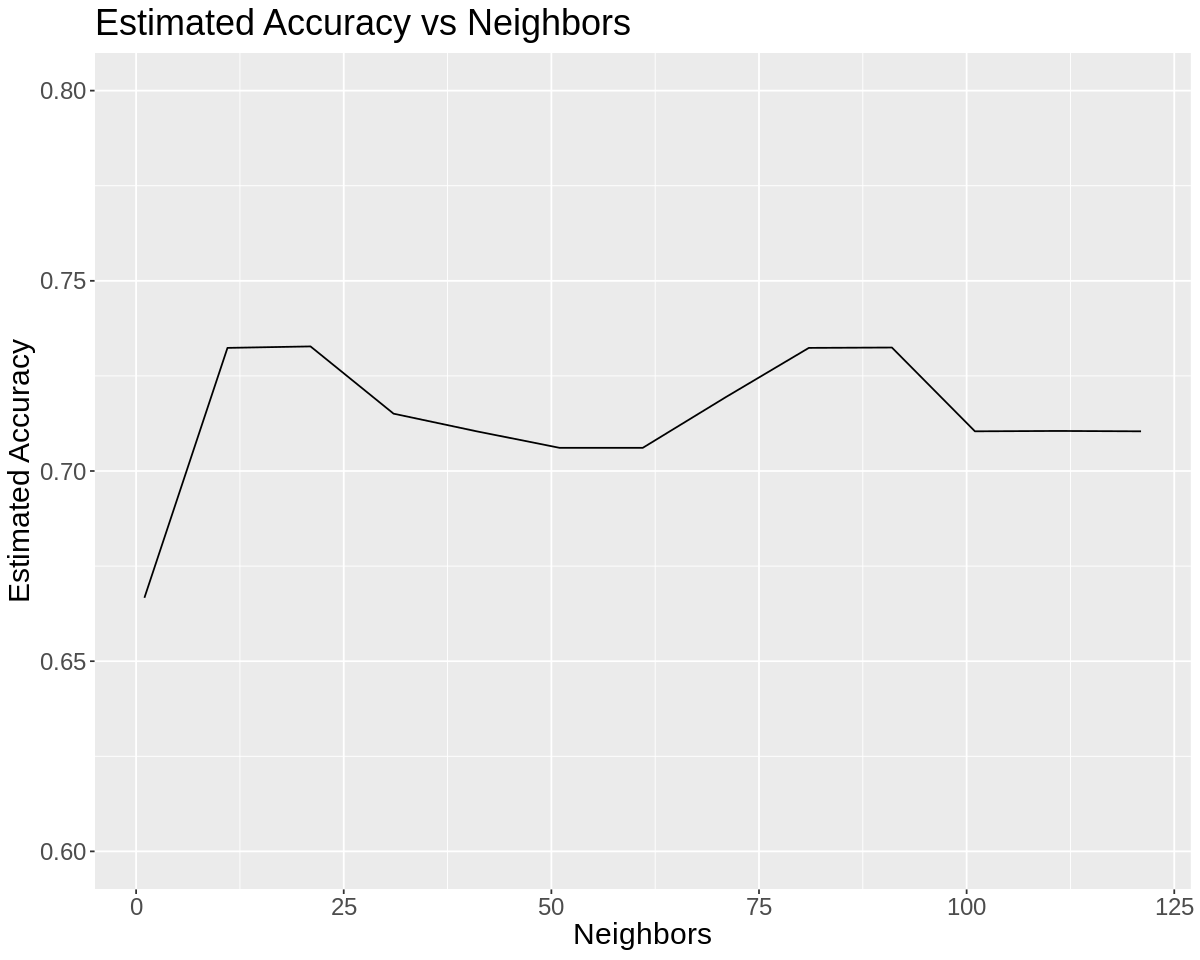

In [14]:
options(repr.plot.width = 10, repr.plot.height = 8)

#plots the estimated accuracy vs K value
accuracy_plot <- ggplot(heart_results_range, aes(x=neighbors, y= mean)) +
    geom_line() +
    ylim(0.6,.8) +
    labs(x="Neighbors", y = "Estimated Accuracy", title = "Estimated Accuracy vs Neighbors") +
    theme(text = element_text(size = 18))
accuracy_plot

Fig 8: Line plot depicting how the estimated accuracy changes with large intervals of K values

In [15]:
#outputs the highest accuracy K value
k_min_range <- heart_results_range %>%
    filter(mean == max(mean)) %>%
    select(neighbors) %>%
    pull()
k_min_range

[1] 21

Now that we know approximately which K value produces the highest estimated accuracy, we can test values of K that are ±5 of `k_min_range` to determine the optimal K value, `k_min`. Once again, we will create a table that displays the accuracy (`mean`) in descending order and extract the K value that produces the maximum accuracy. In addition, we will visualize the results by creating a line plot that graphs how the estimated accuracy changes depending on the K value.

In [16]:
#creates a sequence of K values that will be tested
gridvals <- tibble(neighbors = seq(from = k_min_range - 5, to = k_min_range + 5, by = 1))

#performs the 5 fold cross validation over the given sequence of K values and outputs the data in descending order of accuracy
heart_results <- heart_workflow %>%
    tune_grid(resamples = heart_vfold, grid = gridvals) %>%
    collect_metrics() %>%
    filter(.metric == "accuracy") %>%
    arrange(desc(mean))
head(heart_results)

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
19,accuracy,binary,0.7501449,5,0.03513589,Model04
20,accuracy,binary,0.7501449,5,0.03513589,Model05
17,accuracy,binary,0.7413527,5,0.04274519,Model02
18,accuracy,binary,0.7413527,5,0.04274519,Model03
21,accuracy,binary,0.7327536,5,0.03608259,Model06
22,accuracy,binary,0.7327536,5,0.03608259,Model07


Fig 9: Estimated accuracies of different K values incremented by 1 in descending order

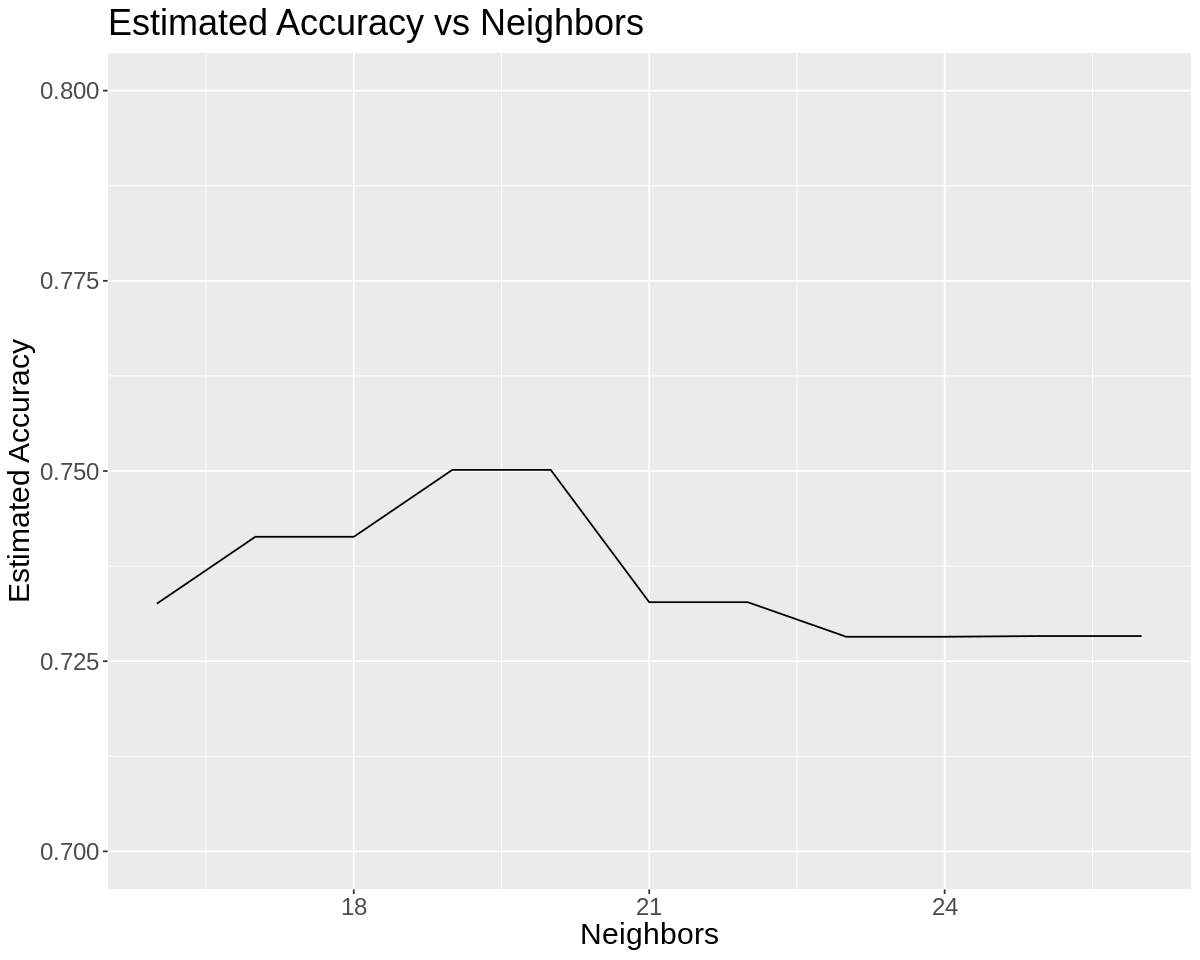

In [17]:
options(repr.plot.width = 10, repr.plot.height = 8)

#plots the estimated accuracy vs K value
accuracy_plot2 <- ggplot(heart_results, aes(x=neighbors, y= mean)) +
    geom_line() +
    ylim(0.7,.8)+
    labs(x="Neighbors", y = "Estimated Accuracy", title = "Estimated Accuracy vs Neighbors") +
    theme(text = element_text(size = 18))
accuracy_plot2

Fig 10: Line plot depicting how the estimated accuracy changes with small intervals of K values

In [18]:
#outputs the highest accuracy K value
k_min <- heart_results %>%
    filter(mean == max(mean)) %>%
    select(neighbors) %>%
    pull()

#sets k_optimal to be the first K value of k_min incase there are two K values with the same accuracy
k_optimal <- k_min[1]
k_optimal

[1] 19

### Testing Accuracy
Now that the optimal k value, `k_optimal` has been determined, we will use this value to create a new classifier and test its accuracy with the `heart_testing` data.

In [19]:
#creates the specification for the model
heart_spec_optimal <- nearest_neighbor(weight = "rectangular", neighbors = k_optimal) %>%
    set_engine("kknn") %>%
    set_mode("classification")

#creates a workflow
heart_fit <- workflow() %>%
    add_recipe(heart_recipe) %>%
    add_model(heart_spec_optimal) %>%
    fit(heart_training)

#creates a tibble with both the predictions and the actual values of the testing data
heart_predictions <- heart_fit %>%
    predict(heart_testing) %>%
    bind_cols(heart_testing)
head(heart_predictions)

.pred_class,age,thalach,oldpeak,Class
<fct>,<dbl>,<dbl>,<dbl>,<fct>
0,41,172,1.4,0
0,44,173,0.0,0
0,48,168,1.0,1
1,60,132,2.4,1
0,50,158,1.6,0
0,58,172,0.0,0


Fig 11: A few observations with our classifiers predictions, `.pred_class`, and their actual classes, `Class`

In [20]:
#produces the actual accuracy of the model
heart_accuracy <- heart_predictions %>%
    metrics(truth = Class, estimate = .pred_class) %>%
    filter(.metric == "accuracy") %>%
    select(.estimate) %>%
    pull()
heart_accuracy

[1] 0.7333333

The accuracy of our classifier with the test data ended up being slightly lower than the estimated accuracy obtained when performing 5-fold cross validation with the training data. Since the classifier performed only marginally worse with the testing set than with the training set, this indicates that our training process with standardization and cross-validation was correctly applied. To get a visual breakdown of how the classifier is performing, we can create a confusion matrix to display counts for each of the different cases.

In [21]:
#produces a table displaying the confusion matrix
confusion <- heart_predictions %>%
    conf_mat(truth = Class, estimate = .pred_class)
confusion

          Truth
Prediction  0  1
         0 33 12
         1  8 22

Fig 12: Confusion matrix for our classifier when tested on the `heart_testing` data

As we can see from the confusion matrix, our classifier made more mistakes with false positives than with false negatives.

## 3. Discussion

### Summary

To summarize the results obtained above, we created a heart disease classifier using KNN with three numerical and relevant predictors for heart disease: age, thalach, and oldpeak. Then we measured the accuracy of our classifier twice on two different ranges of K values (each time narrowing in on the optimal K value) with cross validation. As a result, we found that `K = 19` produced the highest estimated accuracy. Using this K value, we made predictions for the testing data and obtained an accuracy of `73%`.

### Significance

As outlined in the introduction, with this project we want to determine if the variables we chose act as good predictors for our KNN classifier. Then, using those predictors, we created an accurate classifier to detect the presence of heart disease with an accuracy of `73%`. As outlined in `Fig. 12`, our classifier incorrectly predicted many false negatives. This means that if this classifier was the only test for heart disease, some patients with heart disease would go by undetected. Due to this fact, although our classifier is not perfect, it can still serve as a preliminary test that can be used in order to determine if further testing must be done. Since this classifier only requires general medical data about a patient, this classifier could be streamlined and be made available to the public to allow them to monitor their own health and seek medical attention if the results show they might have heart disease. In addition, with more research, we could also extend this classifier to attempt to classify other forms of common diseases such as cancer.

### Future Improvements
To conclude our project, we will propose some ideas that could be implemented to improve the results of our classifier. When using the KNN classifier in our project, every data point has the same weight. One thing that we could consider for future versions of the classifier is, does weighting the points based on how close they are to the new observation increase the accuracy of the classifier? Also, we only chose 3 of the 13 possible attributes to act as predictors for our classifier. How might choosing a different set of predictors alter the results obtained from our analysis?

## 4. References

Chellammal, S., &amp; Sharmila, R. (2019). Recommendation of attributes for heart disease prediction using Correlation Measure. International Journal of Recent Technology and Engineering, 8(2S3), 870–875. https://doi.org/10.35940/ijrte.b1163.0782S319 

Dua, D. and Graff, C. (2019). UCI Machine Learning Repository. Retrieved February 24, 2022, from http://archive.ics.uci.edu/ml. Irvine, CA: University of California, School of Information and Computer Science.

World Health Organization. (n.d.). Cardiovascular diseases. World Health Organization. Retrieved February 28, 2022, from https://www.who.int/health-topics/cardiovascular-diseases 